In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from IPython.display import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from scipy.interpolate import splrep, splev, BSpline, CubicSpline
from sklearn.model_selection import KFold
import warnings
import itertools
warnings.filterwarnings("ignore")
np.random.seed(1)
from ISLP.models import (poly,ModelSpec as MS)
from ISLP.transforms import NaturalSpline
from ISLP.transforms import BSpline
from sklearn.model_selection import KFold
from pygam import LinearGAM, s

## Problem 1

In [2]:
X = np.random.normal(0, 1, 100)
epsilon = np.random.normal(0, 1, 100)
Y = np.sin(0.5 * X) + epsilon
sort = np.argsort(X)
sorted_X = X[sort]
sorted_Y = Y[sort]
R = [2, 3, 4, 5, 6]
knots = [np.quantile(sorted_X, np.linspace(0, 1, k+2))[1:-1] for k in R]

In [3]:
cubic = np.column_stack([X, X**2, X**3])
cubic = sm.add_constant(cubic)
model = sm.OLS(Y, cubic)
output = model.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     9.183
Date:                Wed, 24 May 2023   Prob (F-statistic):           2.12e-05
Time:                        23:51:03   Log-Likelihood:                -133.66
No. Observations:                 100   AIC:                             275.3
Df Residuals:                      96   BIC:                             285.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1281      0.115      1.111      0.269      -0.101       0.357
x1             0.4054      0.187      2.166      0.033       0.034       0.777
x2             0.0246      0.085      0.288      0.774      -0.145       0.194
x3             0.0594      0.065      0.916      0.362      -0.069       0.188
==============================================================================
Omnibus:                        1.539   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.081
Skew:                          -0.236   Prob(JB):                        0.582
Kurtosis:                       3.194   Cond. No.                         5.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

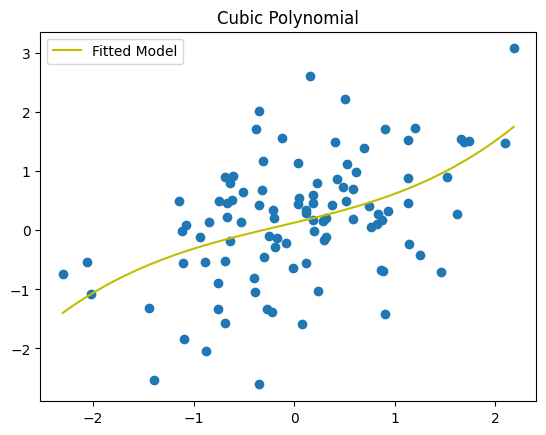

In [4]:
range_x_cubic = np.linspace(X.min(), X.max(), 100)
cubic_plot = np.column_stack([range_x_cubic, range_x_cubic**2, range_x_cubic**3])
cubic_plot = sm.add_constant(cubic_plot)
y_cubic = output.predict(cubic_plot)
plt.scatter(X, Y)
plt.plot(range_x_cubic, y_cubic, color='y', label='Fitted Model')
plt.legend()
plt.title('Cubic Polynomial')
plt.show()

## This is a poor fit as it just provides a very generic idea of the distribution of the data and does not represent it well.

## b.)

In [5]:
sort = np.argsort(X)
sorted_X = X[sort]
sorted_Y = Y[sort]
R = [2, 3, 4, 5, 6]
knots = [np.quantile(sorted_X, np.linspace(0, 1, k+2))[1:-1] for k in R]
rss_list = []
index = KFold(n_splits=5)
for n in knots:
    rss = 0
    for fold in range(5):
        mask = np.arange(100) % 5 == fold
        X_train, Y_train = sorted_X[~mask], sorted_Y[~mask]
        X_val, Y_val = sorted_X[mask], sorted_Y[mask]
        spline = splrep(X_train,Y_train, t = n, k=3)
        Y_pred = splev(X_val,spline)
        rss += mean_squared_error(Y_val,Y_pred)
    rss_list.append(rss)

print("RSS for all knots:", rss_list)
best_knot = R[np.argmin(rss_list)]
print("Best knots = ", best_knot)

RSS for all knots: [4.516316664766195, 4.516404502369923, 4.861571347217594, 5.047959289881939, 5.058918903083686]
Best knots =  2


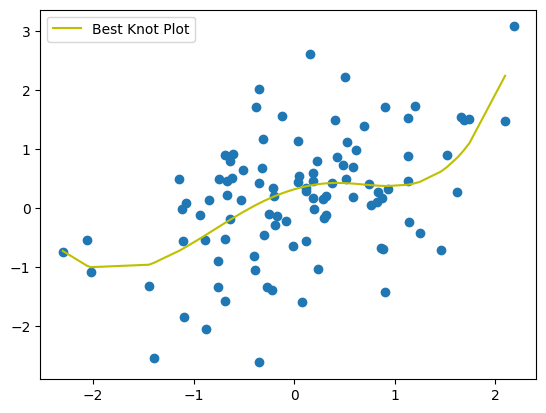

In [6]:
knot = knots[np.argmin(rss_list)]
best_spline = splrep(sorted_X, sorted_Y, t =knot, k =3)
Y_pred_cubic_spline = splev(sorted_X, best_spline)
plt.scatter(X, Y)
plt.plot(sorted_X[:-1], Y_pred_cubic_spline[:-1], color='y', label='Best Knot Plot')
plt.legend()
plt.show()

## This curve fits better and also tries to move towards high density areas to fit the data better. The complexity of the model is high and hence it is more wiggly

## c.)

In [7]:
R = [2, 3, 4, 5, 6]
rss_list = []
index = KFold(n_splits=5)
for r in R:
    rss = 0
    for train, val in index.split(sorted_X):
        X_train, X_val = sorted_X[train], sorted_X[val]
        Y_train, Y_val = sorted_Y[train], sorted_Y[val]
        natural_spline = NaturalSpline(internal_knots=np.percentile(X_train, q=np.linspace(0, 100, r)), intercept=True)
        fitted_x_train = natural_spline.fit_transform(X_train)
        model = sm.OLS(Y_train, fitted_x_train)
        results = model.fit()
        fitted_x_val = natural_spline.transform(X_val)
        Y_pred = results.predict(fitted_x_val)
        rss += mean_squared_error(Y_val,Y_pred)
    rss_list.append(rss)

print("RSS for all knots:", rss_list)
best_knot = R[np.argmin(rss_list)]
print("Best knots = ", best_knot)

RSS for all knots: [5.609419081891354, 5.353431534664239, 6.741645864050171, 11.888576185537259, 9.553487354026192]
Best knots =  3


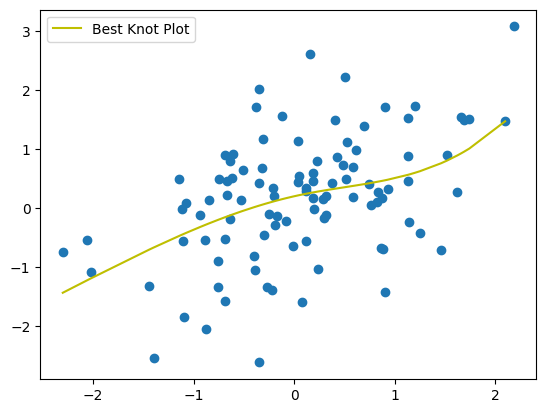

In [8]:
spline = NaturalSpline(internal_knots=np.percentile(sorted_X, q=np.linspace(0,100, best_knot)), intercept=True)
full_data_fit = spline.fit_transform(sorted_X)
model = sm.OLS(sorted_Y, full_data_fit)
results = model.fit()
y_pred_natural = results.predict(full_data_fit)
plt.scatter(sorted_X, sorted_Y)
plt.plot(sorted_X[:-1], y_pred_natural[:-1], color='y', label='Best Knot Plot')
plt.legend()
plt.show()

## This is slighly is smoother and  linear and more generalized and is like curve 1 which is cubic polynomial. I couldn't spot any evident improvement.

## d.)

In [9]:
reg_list = np.logspace(-2, 6, 5)
rss_list = []
index = KFold(n_splits=5)
for l in reg_list:
    rss = 0
    for train, val in index.split(sorted_X):
        X_train, X_val = sorted_X[train], sorted_X[val]
        Y_train, Y_val = sorted_Y[train], sorted_Y[val]
        gam = LinearGAM(s(0, lam=l))
        gam.fit(X_train.reshape((-1, 1)), Y_train)
        Y_pred = gam.predict(X_val.reshape((-1, 1)))
        rss += mean_squared_error(Y_val,Y_pred)
    rss_list.append(rss)
best_l = reg_list[np.argmin(rss_list)]
print("Best Parameter = ", best_l)

Best Parameter =  1000000.0


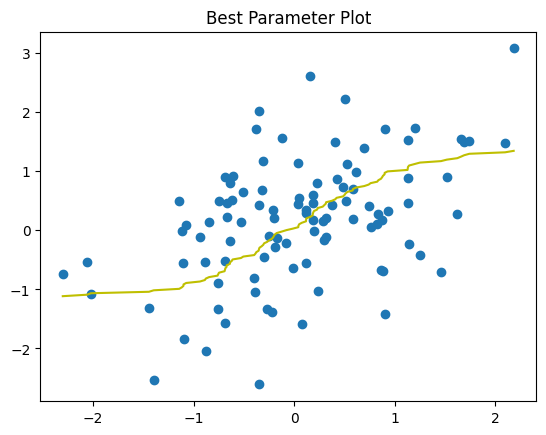

In [10]:
gam = LinearGAM(s(0, lam=best_l))
gam.fit(X.reshape((-1, 1)), Y)
range_x = np.linspace(X.min(), X.max(), 100)
y_pred_smoothing = gam.predict(range_x.reshape((-1, 1)))
plt.scatter(X, Y)
plt.plot(sorted_X, y_pred_smoothing, color='y')
plt.title('Best Parameter Plot')
plt.show()

##  This curve has slight movements up and down where density of points is high but the regularization paramter prevents it from overfitting.

## Comparing all plots

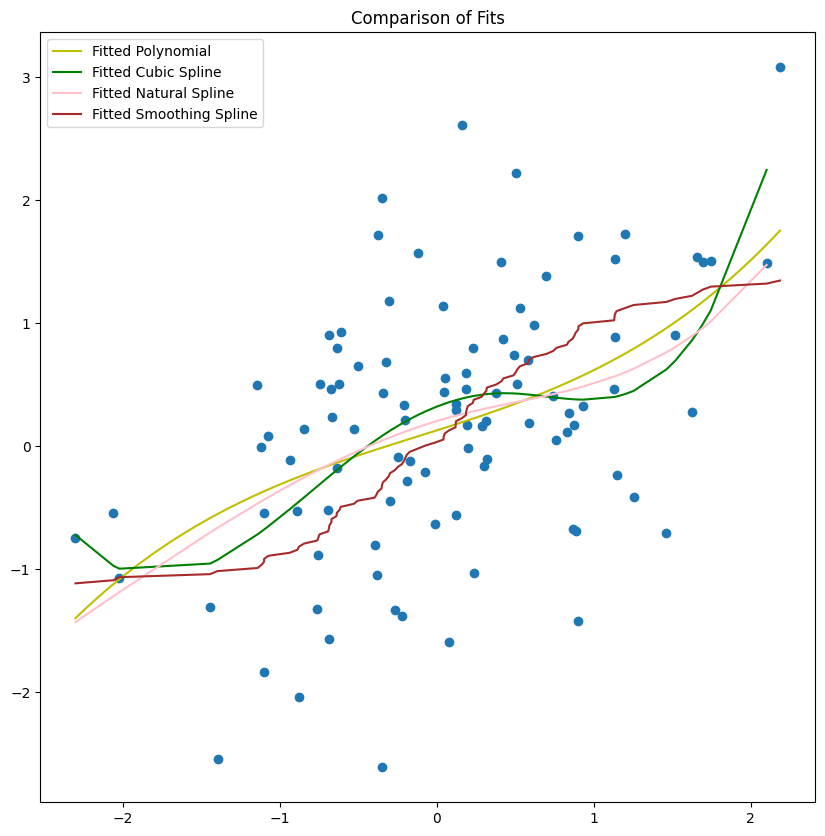

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(range_x_cubic, y_cubic, color='y', label='Fitted Polynomial')
plt.plot(sorted_X[:-1], Y_pred_cubic_spline[:-1], color='g', label='Fitted Cubic Spline')
plt.plot(sorted_X[:-1], y_pred_natural[:-1], color='pink', label='Fitted Natural Spline')
plt.plot(sorted_X, y_pred_smoothing, color='brown', label='Fitted Smoothing Spline')
plt.legend()
plt.title('Comparison of Fits')
plt.show()

## Problem 2

In [12]:
data = pd.read_csv("airQuality.csv")
data["Ozone"] = np.cbrt(data["Ozone"])
print(data.shape)

(153, 6)


In [13]:
data = data.dropna()
X = data[['Solar.R', 'Wind', 'Temp', 'Month', 'Day']]
Y = data['Ozone']
data.shape

(111, 6)

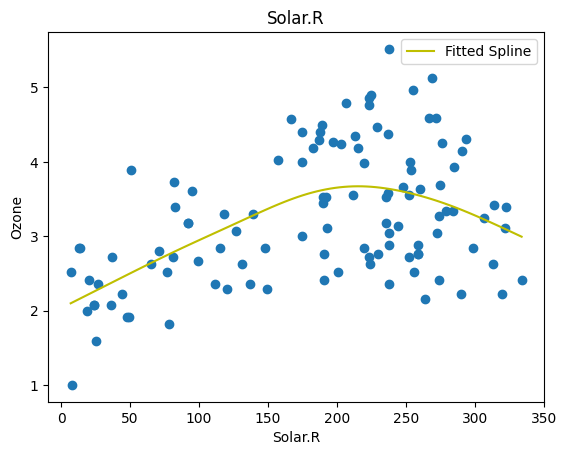

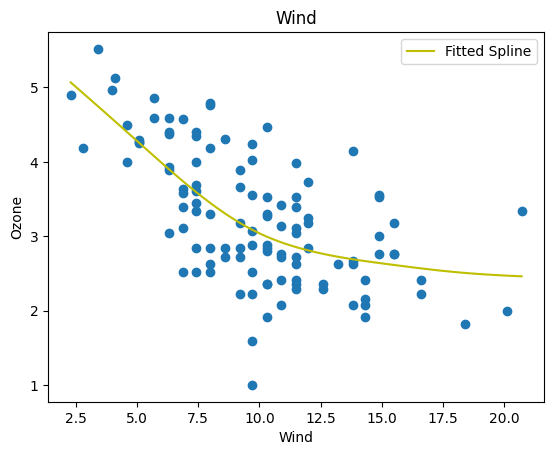

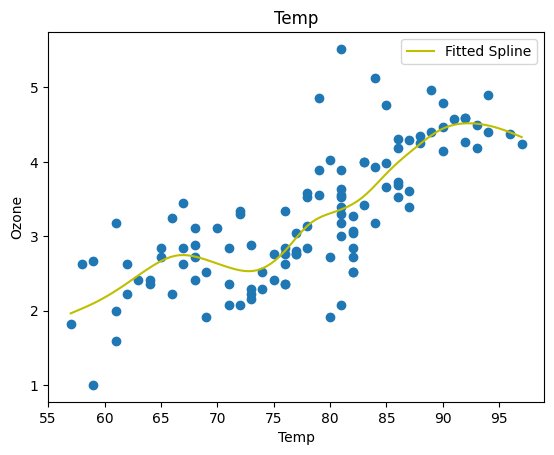

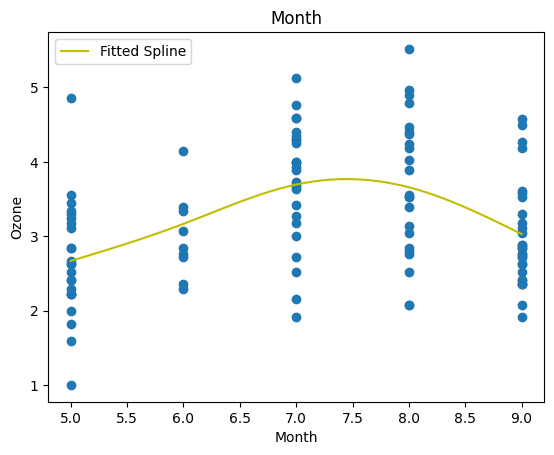

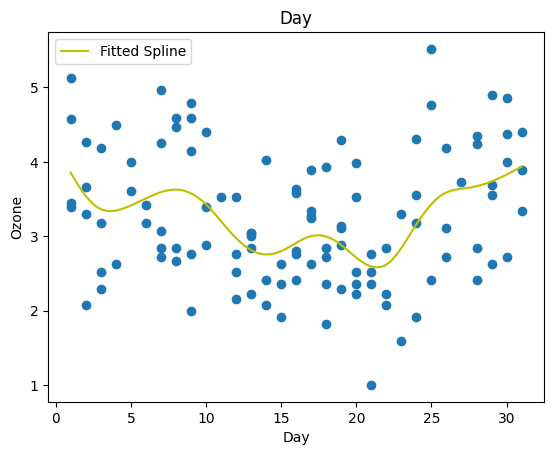

In [14]:
reg_list = np.logspace(-2, 6, 5)
l_list = []
dof_list = []
index = KFold(n_splits=5)
for col in X.columns:
    rss = []
    dof = []
    for l in reg_list:
        cv_rss = []
        cv_dof = []
        for train, val in index.split(X):
            X_train, X_val = X.iloc[train], X.iloc[val]
            Y_train, Y_val = Y.iloc[train], Y.iloc[val]
            gam = LinearGAM(s(0, lam=l))
            gam.fit(X_train[col].values.reshape((-1, 1)), Y_train)
            Y_pred = gam.predict(X_val[col].values.reshape((-1, 1)))
            cv_rss.append(mean_squared_error(Y_val,Y_pred))
            cv_dof.append(gam.statistics_['edof'])
        rss.append(np.mean(cv_rss))
        dof.append(np.mean(cv_dof))
    optimal_l = reg_list[np.argmin(rss)]
    l_list.append(optimal_l)
    dof_list.append(dof[np.argmin(rss)])
    gam = LinearGAM(s(0, lam=optimal_l))
    gam.fit(X[col].values.reshape((-1, 1)), Y)
    X_plot = np.linspace(X[col].min(), X[col].max(), 100)
    Y_plot = gam.predict(X_plot.reshape((-1, 1)))
    plt.scatter(X[col], Y)
    plt.plot(X_plot, Y_plot, color='y', label='Fitted Spline')
    plt.xlabel(col)
    plt.ylabel('Ozone')
    plt.legend()
    plt.title(col)
    plt.show()


## The plot between Solar.R and the Cube Root of Ozone reveals an overall increasing trend, but the curve fails to accurately capture the fit of points, especially at the extremes. Similarly, the plot between Wind and the Cube Root of Ozone indicates a decreasing trend, but the curve struggles to accurately represent the fit of points. The plot between Temp and the Cube Root of Ozone shows a more wiggly curve, but there is a general increasing trend. The plot for Month and Day does not exhibit a clear trend. In summary, the fit for Solar.R, Wind, and Temp variables is relatively better, although the curves may not fully capture the fit of points, particularly at the extremes.

## b.)

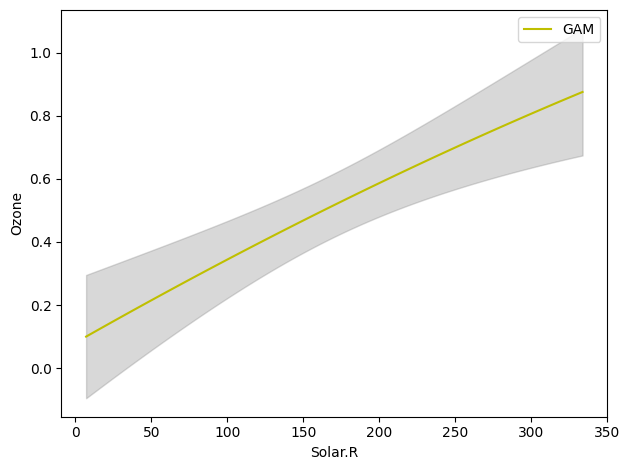

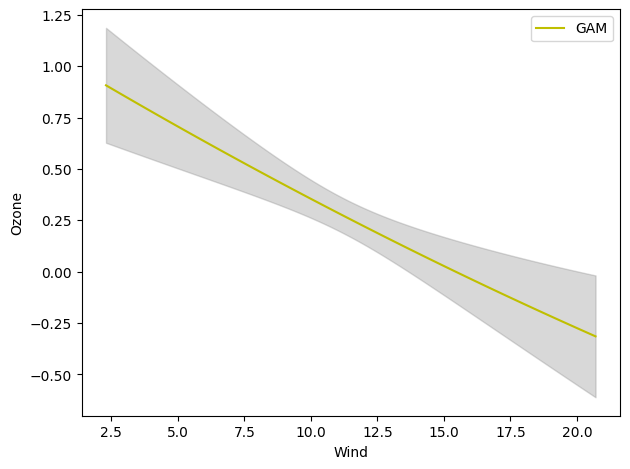

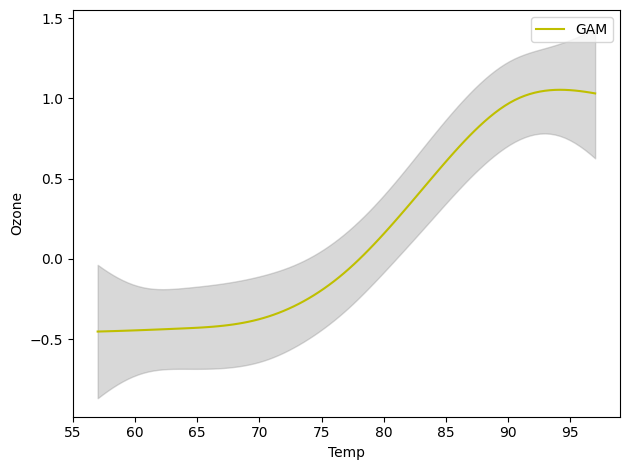

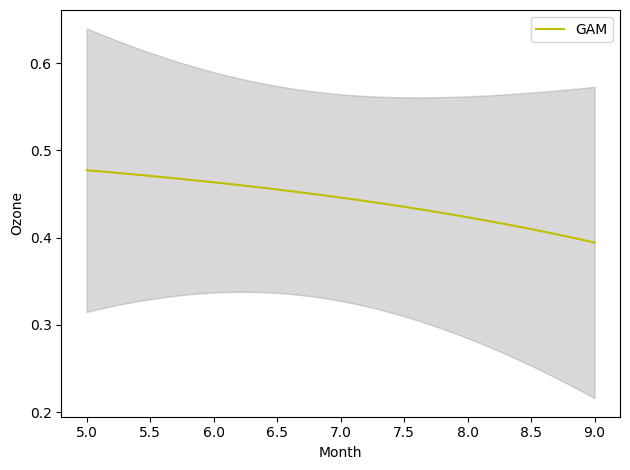

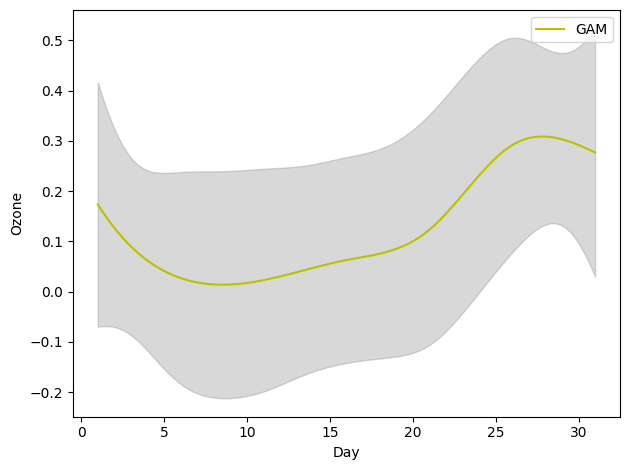

In [15]:
gam_model = LinearGAM( s(0, n_splines=round(dof_list[0])) + s(1, n_splines=round(dof_list[1])) + s(2, n_splines=round(dof_list[2])) + s(3, n_splines=round(dof_list[3])) + s(4, n_splines=round(dof_list[4])), fit_intercept=True)
gam_model.fit(X, Y)
for i in range(1, 6):
    XX = gam_model.generate_X_grid(term=i-1)
    partial_dep, confidence_intervals = gam_model.partial_dependence(term=i-1,X=XX, width=0.95)
    plt.plot(XX[:, i-1], partial_dep, color='y', label='GAM')
    plt.fill_between(XX[:, i-1], confidence_intervals[:, 0],confidence_intervals[:, 1], color='gray', alpha=0.3)  
    plt.xlabel(data.columns[i])
    plt.ylabel("Ozone")
    plt.legend()
    plt.tight_layout()
    plt.show()

##  There is a relationship between the Cube Root of Ozone and Solar.R, Wind, and Temp can be observed. Solar.R  and Temp show a positive association, while Wind exhibits a negative correlation.The plots for Month and Day do not provide show any clear trends or patterns. Overall, the GAM model aligns with the smoothing cubic spline, confirming the impact of Solar.R, Wind, and Temp on the Cube Root of Ozone, while Month and Day show minimal influence.

## c.)

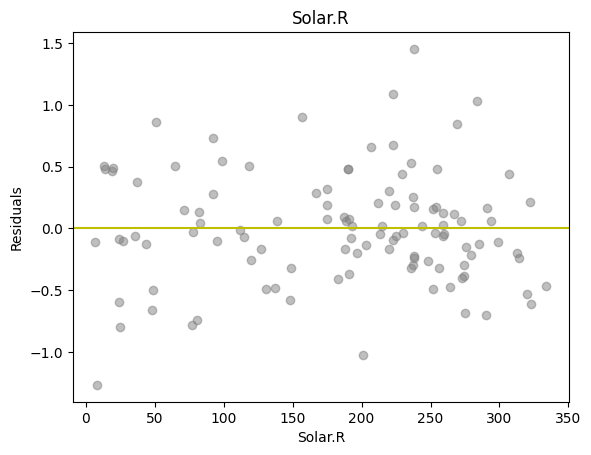

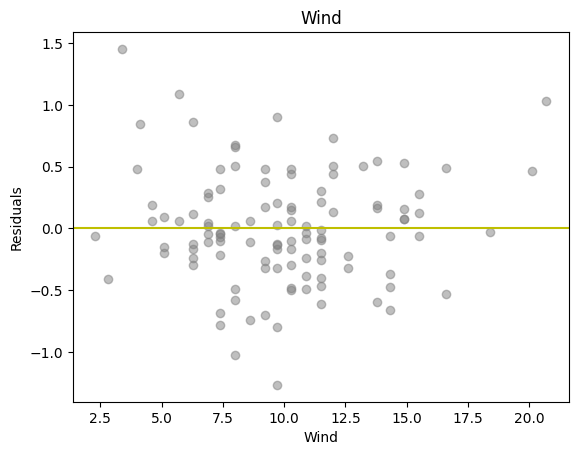

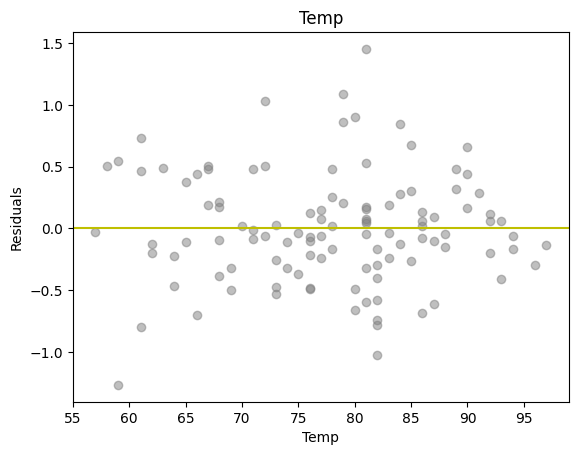

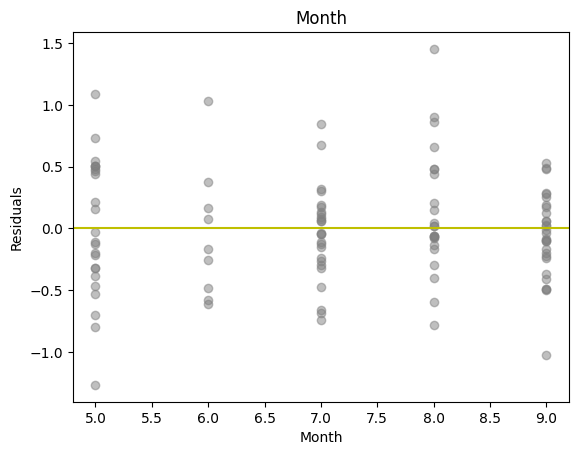

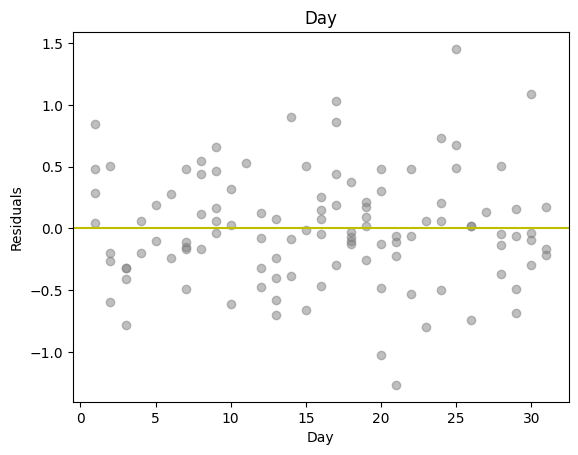

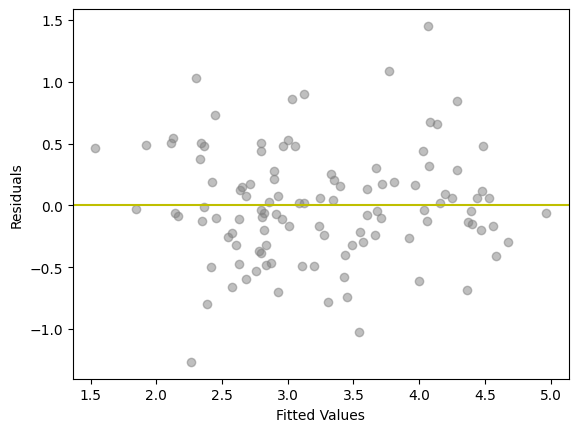

In [16]:
residuals = Y - gam_model.predict(X)
for i, predictor in enumerate(X.columns):
    plt.scatter(data[predictor], residuals, facecolor="gray", alpha=0.5)
    plt.xlabel(predictor)
    plt.ylabel("Residuals")
    plt.title(predictor)
    plt.axhline(0, color="y", linestyle="-")
    plt.show()
plt.scatter(gam_model.predict(X), residuals, facecolor="gray", alpha=0.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(0, color="y", linestyle="-")
plt.show()

## To potentially improve the predictive performance of the GAM model, several approaches can be considered. These include adjusting the degrees of freedom for each predictor, incorporating interaction terms or non-linear transformations, exploring different types of basis functions, tuning the regularization parameter, and conducting thorough model selection and evaluation using appropriate metrics. These strategies aim to find the optimal complexity and flexibility for each predictor, capture complex relationships, and strike a balance between goodness of fit and model complexity. Techniques such as cross-validation can aid in determining the best-performing modifications and selecting the most suitable model.